### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from LDA import LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score


# KNN

### Import the data

In [2]:
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

In [3]:
X_train = data_train[:, :-1]
y_train = data_train[:, -1]
X_test = data_test[:, :-1]
y_test = data_test[:, -1]

### Scale the data

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### LDA

In [5]:
#our LDA
clf = LDA(n_components=4)
clf.fit(X_train_std, y_train)
lda_transformed_X_train= clf.transform(X_train)
lda_transformed_X_test = clf.transform(X_test)

print(X_test.shape, lda_transformed_X_train.shape)

(5000, 784) (10000, 4)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

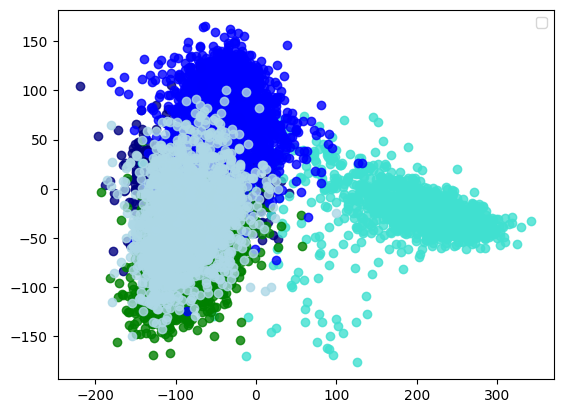

In [6]:
plt.figure()
colors = ["navy", "turquoise", "green", 'blue', 'lightblue']

lw = 2
plt.figure()
for color, i in zip(colors, [0, 1, 2, 3, 4]):
    plt.scatter(
        lda_transformed_X_train[y_train == i, 0], lda_transformed_X_train[y_train == i, 1], alpha=0.8, color=color
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
#plt.savefig()
#plt.title("LDA of IRIS dataset")

plt.show()

### PCA 

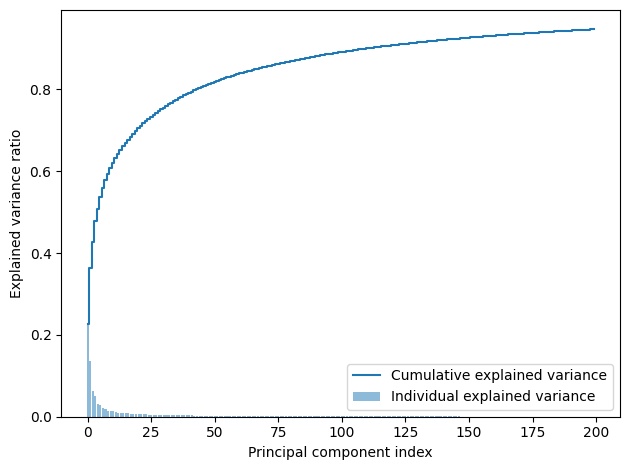

In [7]:
#PCA using sklearn
pca = PCA(n_components= 200)
pca_transformed_X_train= pca.fit_transform(X_train_std, y_train)
pca_X_test_transformed = pca.transform(X_test_std)

# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("explained_variance_ratio_pca.png")
plt.show()

In [8]:
pca = PCA(0.90).fit(X_train_std)
pca.n_components_

112

since 112 components explain 90% of the data 2we set the components = 112

In [9]:
pca = PCA(n_components= 112)
pca_transformed_X_train= pca.fit_transform(X_train_std, y_train)
pca_X_test_transformed = pca.transform(X_test_std)

In [10]:

def KNN_accuracy(X_train,y_train,X_test,y_test):
    """
    returns accuracy of KNN classifier

    Inputs:
    - X_train: Training data features (numpy array or pandas DataFrame)
    - y_train: Training data labels (numpy array or pandas Series)
    - X_test: Testing data features (numpy array or pandas DataFrame)
    - y_test: Testing data labels (numpy array or pandas Series)

    Output:
    - accuracy_score: the accuracy of the KNN classifier on the test data.
    It is calculated as the ratio of correctly predicted instances to the total number of instances.(float)


    """
    neigh = KNeighborsClassifier(n_neighbors=21)
    neigh.fit(X_train, y_train)
    predictions = (neigh.predict(X_test))

    accuracy_score = np.sum(predictions== y_test)/len(y_test)
    return accuracy_score



### Cross validation

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [11]:
def cross_val_regular(X,y,n,cv):
    """computing cross validation for n neighbours
        input: 
        X:
        y:
        n (int): number of neighbours
        cv(int): number og splits in the cross validation

        output: accuracy scores for each split
        
        
        """
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X, y)
    scores = cross_val_score(neigh, X, y, cv=cv)
    return scores

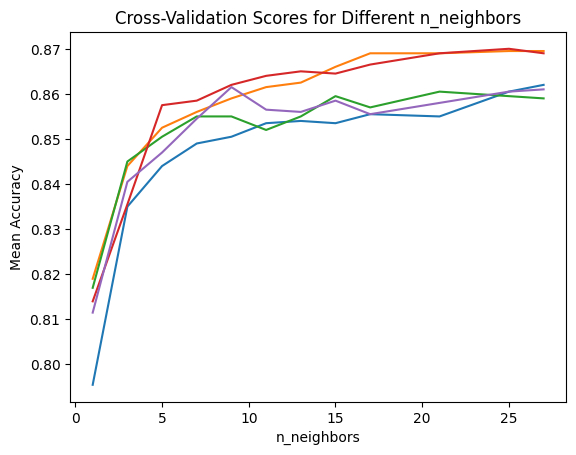

In [13]:
n_values = [1, 3,5,7,9,11,13,15,17,21,25,27]
cv=5
def cross_val_plot(X,y,n_values,cv):
    """ plot the different cross validation scores from each split
        input:
        X: 
        y:
        n(list): number of neighbours
        cv (int):number of splits
        
        output: accuracy score for each split
        
        """
    all_scores = []
    for n in n_values:
        scores = cross_val_regular(X, y, n, cv)
        all_scores.append(scores)
    
    
    # Plotting
    plt.plot(n_values, all_scores, marker='none')
    plt.title('Cross-Validation Scores for Different n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.show()


#cross_val_plot(X_train,y_train, n_values, cv)
cross_val_plot(lda_transformed_X_train,y_train,n_values,cv)

In [14]:
def cross_val_mean(X, y, n, cv):
    """
    Calculates the mean score fromo each split in the cross validation

    input:
    X:
    y:
    n(int): number of neighbours
    cv (int): number of splits

    output: mean score from each split
    """
    classifier = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(classifier, X, y, cv=cv)
    return np.mean(scores)  # Return the mean score

cross validating for diferent number of n neighbours on the different datasets

In [15]:
#seting number of neighbours and number of splits in the cross validation
n_values = [1, 3, 5, 7, 11, 13, 15, 17, 19, 21, 23]
cv = 5

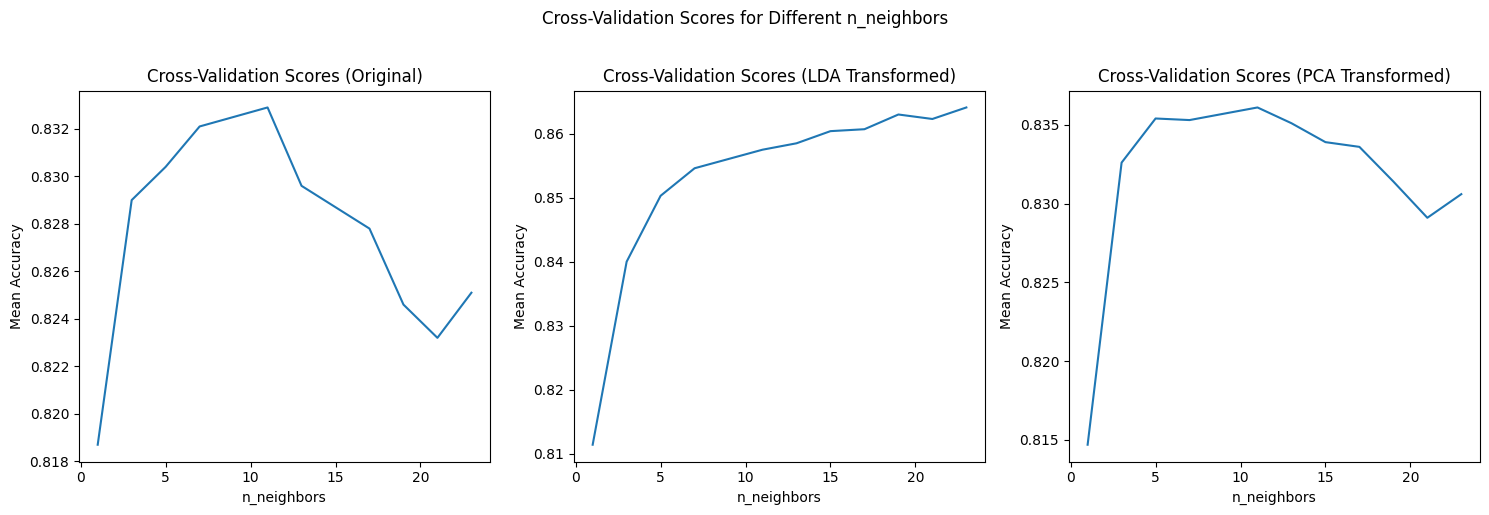

In [16]:
datasets = [(X_train, 'Original'), (lda_transformed_X_train, 'LDA Transformed'), (pca_transformed_X_train, 'PCA Transformed')]

# Create subplots
fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5)) 

for i, (X, label) in enumerate(datasets):
    all_scores = [cross_val_mean(X, y_train, n, cv) for n in n_values]
    axs[i].plot(n_values, all_scores, marker='none')
    axs[i].set_title(f'Cross-Validation Scores ({label})')
    axs[i].set_xlabel('n_neighbors')
    axs[i].set_ylabel('Mean Accuracy')


plt.suptitle('Cross-Validation Scores for Different n_neighbors', y=1.02)
plt.tight_layout()
plt.show()


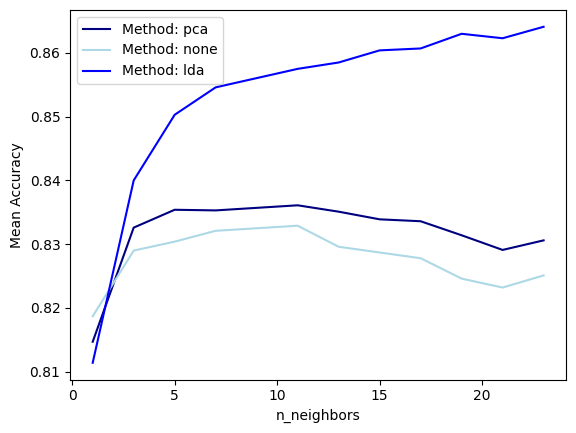

In [17]:
def cross_val_plot(data_sets, n_values, cv):
    """
    plots the accuracy scores from each split for different number of neighbours
    input:
    data_sets:
    n_values:
    cv(int): number of splits 
    
    output: accuracy scores from each split plotted
    """
    Methods = ['pca', 'none', 'lda']
    colors = ["navy", "lightblue", 'blue']
    for i, (X_train, y_train) in enumerate(data_sets):
        method_name = Methods[i]
        all_scores = [cross_val_mean(X_train, y_train, n, cv) for n in n_values]
        plt.plot(n_values, all_scores, marker='none', label=f'Method: {method_name}', color=colors[i])

    # Plotting
    #plt.title('Cross-Validation Scores for Different n_neighbors')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.legend()
    plt.savefig('cross_val_pca_lda_none.png')
    plt.show()

# Assuming pca_transformed_X_train, y_train, and another set of X_train, y_train are your datasets
data_sets = [(pca_transformed_X_train, y_train), (X_train, y_train), (lda_transformed_X_train, y_train)]

# Also, assuming n_values is a list of hyperparameter values to be tested
cross_val_plot(data_sets, n_values, cv=5)


investigating LDA further

In [18]:
def lda_multi(n_components):
    clf = LDA(n_components)
    clf.fit(X_train, y_train)
    lda_transformed_X_train= clf.transform(X_train)
    return lda_transformed_X_train, y_train
    

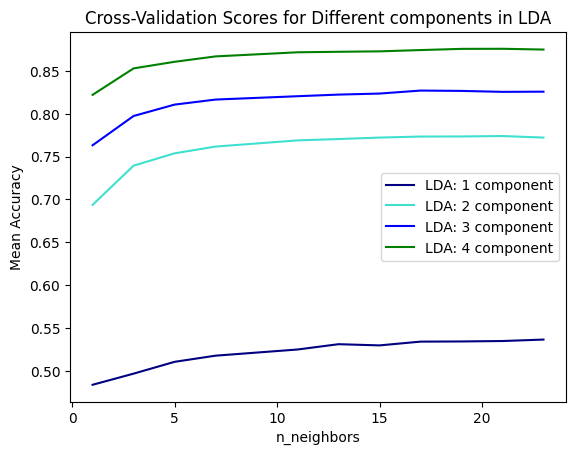

In [19]:
def cross_val_plot_lda(data_sets, n_values, cv):
    """
    plots the different accuracy scores for each split for different number of 
    neighbours for LDA datasets with different number of components

    inputs: 
    data_sets:
    n_values (list): number of neighbours
    cv (int) number of splits
    
    output: cross validation scores plotted
    """
    Methods = ['1 component', '2 component', '3 component','4 component']
    colors = ['navy', 'turquoise', 'blue','green']
    for i, (X_train, y_train) in enumerate(data_sets):
        method_name = Methods[i]
        all_scores = [cross_val_mean(X_train, y_train, n, cv) for n in n_values]
        plt.plot(n_values, all_scores, marker='none', label=f'LDA: {method_name}',color=colors[i])

    # Plotting
    plt.title('Cross-Validation Scores for Different components in LDA')
    plt.xlabel('n_neighbors')
    plt.ylabel('Mean Accuracy')
    plt.legend()
    plt.savefig('cross_val_diff_lda_plot.png')
    plt.show()

data_sets = [(lda_multi(1)), (lda_multi(2)), (lda_multi(3)),(lda_multi(4))]

cross_val_plot_lda(data_sets,n_values,cv=5)


### Train final classifier

In [47]:
# Train and apply LDA
lda = LDA(n_components=4)
lda.fit(X_train, y_train)
lda_transformed_X_train = lda.transform(X_train)
lda_transformed_X_test = lda.transform(X_test)

# KNN
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(lda_transformed_X_train, y_train);

In [48]:
yhat = knn.predict(lda_transformed_X_test)
yhat_proba = knn.predict_proba(lda_transformed_X_test)

### Test

In [49]:
accuracy_score(y_test, yhat)

0.8134

In [50]:
_confusion_matrix=confusion_matrix(y_test, yhat)
_confusion_matrix

array([[801,   3,  27,  56, 113],
       [  7, 953,   6,  30,   4],
       [ 22,   2, 835,  18, 123],
       [ 51,  10,  14, 879,  46],
       [164,   4, 167,  66, 599]], dtype=int64)

In [51]:
test_scores = {'Class':[], 'Recall': [], 'Precision': []}

for i in range(5):
    TP = _confusion_matrix[i,i]
    FP = sum(_confusion_matrix[:,i])-TP
    FN = sum(_confusion_matrix[i,:])-TP
    TN = np.sum(_confusion_matrix)- TP-FP-FN

    test_scores['Class'].append(i)

    # Recall: TP/(TP+FN)
    test_scores['Recall'].append(TP/(TP+FN))
    # Precision: TP/(TP+FP)
    test_scores['Precision'].append(TP/(TP+FP))

In [52]:
test_scores_df = pd.DataFrame(test_scores)
test_scores_df

,Class,Recall,Precision
0,0,0.801,0.766507
1,1,0.953,0.980453
2,2,0.835,0.795996
3,3,0.879,0.837941
4,4,0.599,0.676836
